In [221]:
import boto3
import pandas as pd; pd.set_option('display.max_column', 100)
import numpy as np
import warnings
warnings.simplefilter(action= 'ignore', category=FutureWarning)


from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt



s3= boto3.resource('s3')
bucket_name= 'morgangant-bata-445-bucket'
bucket= s3.Bucket(bucket_name)

file_key1= 'churn-bigml-80.csv'
file_key2= 'churn-bigml-20.csv'


bucket_object1= bucket.Object(file_key1)
file_object1= bucket_object1.get()
file_content_stream1 = file_object1.get('Body')

bucket_object2= bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

#reading the datefile
telecom_train = pd.read_csv(file_content_stream1)
telecom_test= pd.read_csv(file_content_stream2)

In [2]:
telecom_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
telecom_test.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn
0,LA,117,408,No,No,0,184.5,97,31.37,351.6,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False
1,IN,65,415,No,No,0,129.1,137,21.95,228.5,83,19.42,208.8,111,9.40,12.7,6,3.43,4,True
2,NY,161,415,No,No,0,332.9,67,56.59,317.8,97,27.01,160.6,128,7.23,5.4,9,1.46,4,True
3,SC,111,415,No,No,0,110.4,103,18.77,137.3,102,11.67,189.6,105,8.53,7.7,6,2.08,2,False
4,HI,49,510,No,No,0,119.3,117,20.28,215.1,109,18.28,178.7,90,8.04,11.1,1,3.00,1,False


In [222]:
telecom_train= pd.DataFrame(telecom_train)
telecom_test= pd.DataFrame(telecom_test)

In [223]:
#Changing Churn true/false to 1/0
telecom_train['Churn']= telecom_train['Churn'].astype(int)
telecom_test['Churn']= telecom_test['Churn'].astype(int)

#Changing International_plan yes/no to 1/0
telecom_train['International_plan'].replace(['Yes', 'No'], [1,0], inplace= True)
telecom_test['International_plan'].replace(['Yes', 'No'], [1,0], inplace= True)

#Changing Voice_mail_plan yes/no to 1/0
telecom_train['Voice_mail_plan'].replace(['Yes', 'No'], [1,0], inplace= True)
telecom_test['Voice_mail_plan'].replace(['Yes', 'No'], [1,0], inplace= True)

#Creating variable Total_charge
telecom_train= telecom_train.assign(total_charge= telecom_train['Total_day_charge'] + telecom_train['Total_eve_charge'] + telecom_train['Total_night_charge']+ telecom_train['Total_intl_charge'])
telecom_test= telecom_test.assign(total_charge= telecom_test['Total_day_charge'] + telecom_test['Total_eve_charge'] + telecom_test['Total_night_charge']+ telecom_test['Total_intl_charge'])

In [143]:
telecom_train.head()

,State,Account_length,Area_code,International_plan,Voice_mail_plan,Number_vmail_messages,Total_day_minutes,Total_day_calls,Total_day_charge,Total_eve_minutes,Total_eve_calls,Total_eve_charge,Total_night_minutes,Total_night_calls,Total_night_charge,Total_intl_minutes,Total_intl_calls,Total_intl_charge,Customer_service_calls,Churn,total_charge
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,75.56
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0,59.24
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,62.29
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,66.80
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,52.09


In [224]:
telecom_train= telecom_train.drop(columns= ['State','Area_code', 'Number_vmail_messages', 'Total_day_minutes', 'Total_day_calls', 'Total_day_charge', 'Total_eve_minutes', 'Total_eve_calls','Total_eve_charge', 'Total_night_minutes', 'Total_night_calls', 'Total_night_charge', 'Total_intl_minutes', 'Total_intl_calls', 'Total_intl_charge'], axis=1)
telecom_test= telecom_test.drop(columns= ['State','Area_code', 'Number_vmail_messages', 'Total_day_minutes', 'Total_day_calls', 'Total_day_charge', 'Total_eve_minutes', 'Total_eve_calls','Total_eve_charge', 'Total_night_minutes', 'Total_night_calls', 'Total_night_charge', 'Total_intl_minutes', 'Total_intl_calls', 'Total_intl_charge'], axis=1)

In [225]:
telecom_test.head()

,Account_length,International_plan,Voice_mail_plan,Customer_service_calls,Churn,total_charge
0,117,0,0,1,0,73.32
1,65,0,0,4,1,54.20
2,161,0,0,4,1,92.29
3,111,0,0,2,0,41.05
4,49,0,0,1,0,49.60


In [226]:
#Setting x and y variables
x = telecom_train[['Account_length', 'International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
y = telecom_train['Churn']

In [190]:
df= list()
for i in range(0,1000):
    #Splitting the Data
    x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, stratify= y)
    
    #Min Max Scaler
    scaler= MinMaxScaler()
    x_train= scaler.fit_transform(x_train)
    x_test= scaler.fit_transform(x_test)
    
    #Estimating lambda for lasso
    lasso_cv= LassoCV(normalize= True, cv=5).fit(x_train, y_train)

    #Extracting best lambda
    cv_lambda= lasso_cv.alpha_
    #print('Estimated lambda for the lasso model is:', cv_lambda)
    
    #Building lasso
    lasso_md= Lasso(alpha= cv_lambda, normalize= True).fit(x_train, y_train)
    df.append(lasso_md.coef_)

In [127]:
A = pd.DataFrame(df)
A

,0,1,2,3,4
0,0.000000,0.291997,-0.059685,0.452929,0.469105
1,0.053459,0.349514,-0.076151,0.525720,0.509018
2,0.016304,0.325814,-0.066054,0.503215,0.449359
3,0.010107,0.318285,-0.069370,0.493793,0.523768
4,0.000000,0.304724,-0.072000,0.465921,0.503896
...,...,...,...,...,...
995,0.022768,0.333101,-0.076179,0.449042,0.543739
996,0.026184,0.302845,-0.077790,0.540267,0.532652
997,0.035971,0.327899,-0.074325,0.487787,0.513152
998,0.000000,0.314059,-0.057807,0.424694,0.518108


In [160]:
print(sum(A[0] == 0.0))
print(sum(A[1] == 0.0))
print(sum(A[2] == 0.0))
print(sum(A[3] == 0.0))
print(sum(A[4] == 0.0))

253
0
0
0
0


In [227]:
#Dropping Account_length and Voice_mail_plan
telecom_train= telecom_train.drop(columns= ['Account_length'], axis=1)
telecom_test= telecom_test.drop(columns= ['Account_length'], axis=1)
telecom_train.head()

,International_plan,Voice_mail_plan,Customer_service_calls,Churn,total_charge
0,0,1,1,0,75.56
1,0,1,1,0,59.24
2,0,0,0,0,62.29
3,1,0,2,0,66.80
4,1,0,3,0,52.09


In [192]:
#Setting x and y variables
x = telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
y = telecom_train['Churn']

#Lists to store results
md1_results= list()
md2_results= list()
md3_results= list()
md4_results= list()

for i in range(0,100):
    
    kfold= StratifiedKFold(n_splits=5, shuffle=True)
   
    #Defining list to store
    md1_fold_result= list()
    md2_fold_result= list()
    md3_fold_result= list()
    md4_fold_result= list()
    
    #Min Max Scaler
    scaler=MinMaxScaler()
    x=pd.DataFrame(scaler.fit_transform(x))
    
    for train_ix, val_ix in kfold.split(x, y):
        #Splitting data
        x_train, x_val= x.iloc[train_ix], x.iloc[val_ix]
        y_train, y_val= y.iloc[train_ix], y.iloc[val_ix]
        
        
        #Model 1
        #Building the linear model
        md1= LogisticRegression(solver='liblinear', penalty='l1').fit(x_train, y_train)
        #Predicting on the validation set
        md1_pred= md1.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md1_labels=np.where(md1_pred<0.10,0,1)
        #Computing recall score and storing it
        md1_recall= recall_score(y_val, md1_labels)
        md1_fold_result.append(md1_recall)
        
    
        #Model 2
        #Building the linear model
        md2= LogisticRegression(solver='liblinear', penalty='l2').fit(x_train, y_train)
        #Predicting on the validation set
        md2_pred= md2.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md2_labels=np.where(md2_pred<0.10,0,1)
        #Computing recall score and storing it
        md2_recall= recall_score(y_val, md2_labels)
        md2_fold_result.append(md2_recall)

       
        #Model 3
        #Building the linear model
        md3= LogisticRegression(solver='saga', penalty='l1').fit(x_train, y_train)
        #Predicting on the validation set
        md3_pred= md3.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md3_labels=np.where(md3_pred<0.10,0,1)
        #Computing recall score and storing it
        md3_recall= recall_score(y_val, md3_labels)
        md3_fold_result.append(md3_recall)


        #Model 4
        #Building the linear model
        md4= LogisticRegression(solver='saga', penalty='l2').fit(x_train, y_train)
        #Predicting on the validation set
        md4_pred= md4.predict_proba(x_val)[:,1]
        #Setting 10% cut-off
        md4_labels=np.where(md4_pred<0.10,0,1)
        #Computing recall score and storing it
        md4_recall= recall_score(y_val, md4_labels)
        md4_fold_result.append(md4_recall)
        
    avg1= np.mean(md1_fold_result)  
    md1_results.append(avg1)
    avg2= np.mean(md2_fold_result)  
    md2_results.append(avg2)
    avg3= np.mean(md3_fold_result)  
    md3_results.append(avg3)
    avg4= np.mean(md4_fold_result)  
    md4_results.append(avg4)
    
    #Overall Means of the 100 iterations per model
    print('Iteration', [i])
    print('Average Recall for model 1, iteration:', np.mean(md1_results))
    print('Average Recall for model 2:',np.mean(md2_results))
    print('Average Recall for model 3:',np.mean(md3_results))
    print('Average Recall for model 4:',np.mean(md4_results))

Iteration [0]
Average Recall for model 1, iteration: 0.8556443556443556
Average Recall for model 2: 0.8762570762570763
Average Recall for model 3: 0.8504828504828504
Average Recall for model 4: 0.8634032634032633
Iteration [1]
Average Recall for model 1, iteration: 0.8516983016983016
Average Recall for model 2: 0.8813519813519815
Average Recall for model 3: 0.8504162504162505
Average Recall for model 4: 0.8658841158841158
Iteration [2]
Average Recall for model 1, iteration: 0.8512931512931513
Average Recall for model 2: 0.8822510822510822
Average Recall for model 3: 0.8504384504384505
Average Recall for model 4: 0.8693528693528694
Iteration [3]
Average Recall for model 1, iteration: 0.8523976023976023
Average Recall for model 2: 0.8820596070596071
Average Recall for model 3: 0.8498251748251748
Average Recall for model 4: 0.8691558441558442
Iteration [4]
Average Recall for model 1, iteration: 0.8535930735930736
Average Recall for model 2: 0.883010323010323
Average Recall for model 3: 0.

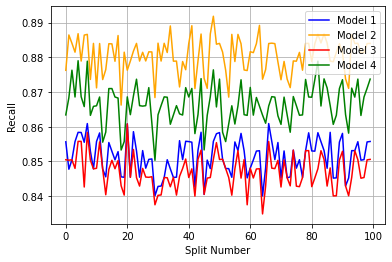

In [193]:
x= [i for i in range(0,100)]
plt.plot(x, md1_results, color = 'blue')
plt.plot(x, md2_results, color = 'orange')
plt.plot(x, md3_results, color = 'red')
plt.plot(x, md4_results, color = 'green')
plt.xlabel('Split Number')
plt.ylabel('Recall')
plt.legend(loc = 'upper right', labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4'])
plt.grid()
plt.show();

In [ ]:
#Model 2, using the solver Liblinear and penalty L2 is the better out of model 1 and 2 based on recall values.
#Model 4, using the solver saga and penalty L2 is the better out of model 3 and 4 based on recall values.

In [234]:
#Redefining the variables
x_train= telecom_train[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
y_train= telecom_train['Churn']

x_test= telecom_test[['International_plan', 'Voice_mail_plan', 'total_charge', 'Customer_service_calls']]
y_test= telecom_test['Churn']

#Min Max Scaler
scaler= MinMaxScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.fit_transform(x_test)


#Model 1
#Building the linear model
m1= LogisticRegression(solver='liblinear', penalty='l2').fit(x_train, y_train)
#Predicting on the validation set
m1_pred= m1.predict_proba(x_test)[:,1]
#Setting 10% cut-off
m1_labels=np.where(m1_pred<0.10,0,1)
#Computing recall score and storing it
m1_recall= recall_score(y_test, m1_labels)


#Model 2
#Building the linear model
m2= LogisticRegression(solver='saga', penalty='l2').fit(x_train, y_train)
#Predicting on the validation set
m2_pred= m2.predict_proba(x_test)[:,1]
#Setting 10% cut-off
m2_labels=np.where(m2_pred<0.10,0,1)
#Computing recall score and storing it
m2_recall= recall_score(y_test, m2_labels)

print('Recall score for model 1:', m1_recall)
print('Recall score for model 2:', m2_recall)

Recall score for model 1: 0.9157894736842105
Recall score for model 2: 0.9157894736842105


In [ ]:
#Based on the recall values above, they are the same so either model could be chosen. However, by looking at the question above, we see on avaerge, the model using the solver
#Liblinear and penalty L2 is the better average model. For that reason, I would say to go with model 1 in this instance, even though for 1 iteration, they are the same.